In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
# If using transformers:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

In [38]:
#Download NLTK data (once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
# --- Upload datasets manually (works in Colab) ---
from google.colab import files
uploaded = files.upload()  # select both CSVs

# Use the uploaded filenames directly
FAKE_PATH = "Fake_India_100_formatted.csv"
TRUE_PATH = "True_India_100_formatted.csv"

# Load datasets
import pandas as pd
fake = pd.read_csv(FAKE_PATH)
true = pd.read_csv(TRUE_PATH)

print("Fake shape:", fake.shape)
print("True shape:", true.shape)


Saving Fake_India_100_formatted.csv to Fake_India_100_formatted (3).csv
Saving True_India_100_formatted.csv to True_India_100_formatted (3).csv
Fake shape: (100, 4)
True shape: (100, 4)


Dataset size: (200, 5)
label
1    100
0    100
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


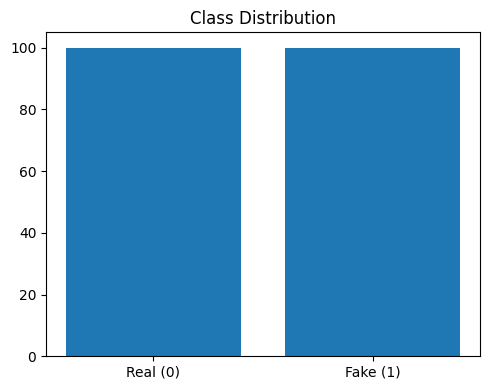

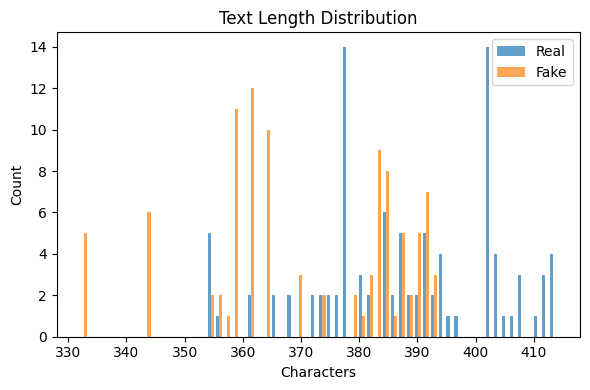


Logistic Regression
Accuracy=100.00% | Precision=100.00% | Recall=100.00% | F1=100.00% | Specificity=100.00% | AUC=100.00%
              precision    recall  f1-score   support

     REAL(0)       1.00      1.00      1.00        20
     FAKE(1)       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



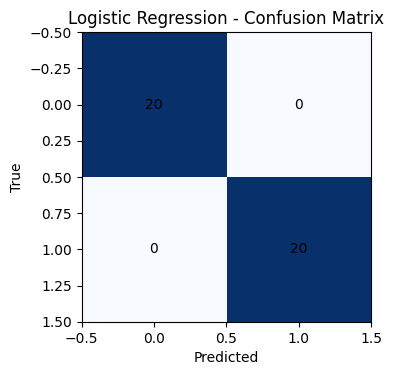

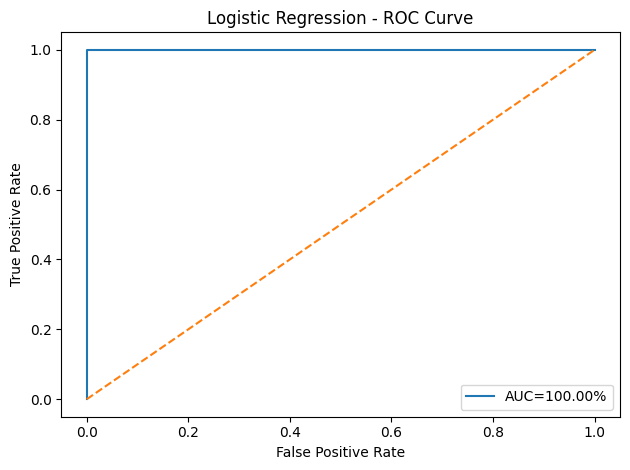


Random Forest
Accuracy=100.00% | Precision=100.00% | Recall=100.00% | F1=100.00% | Specificity=100.00% | AUC=100.00%
              precision    recall  f1-score   support

     REAL(0)       1.00      1.00      1.00        20
     FAKE(1)       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



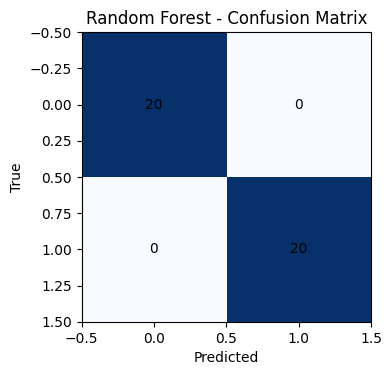

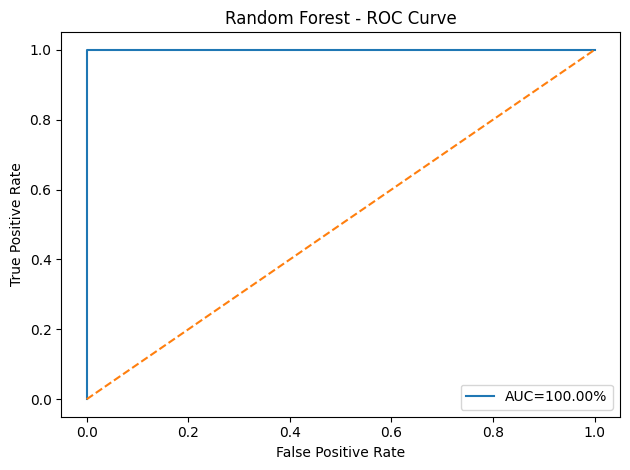


XGBoost
Accuracy=100.00% | Precision=100.00% | Recall=100.00% | F1=100.00% | Specificity=100.00% | AUC=100.00%
              precision    recall  f1-score   support

     REAL(0)       1.00      1.00      1.00        20
     FAKE(1)       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



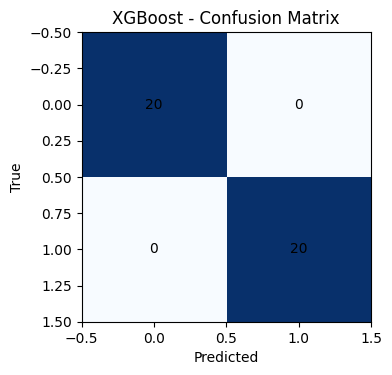

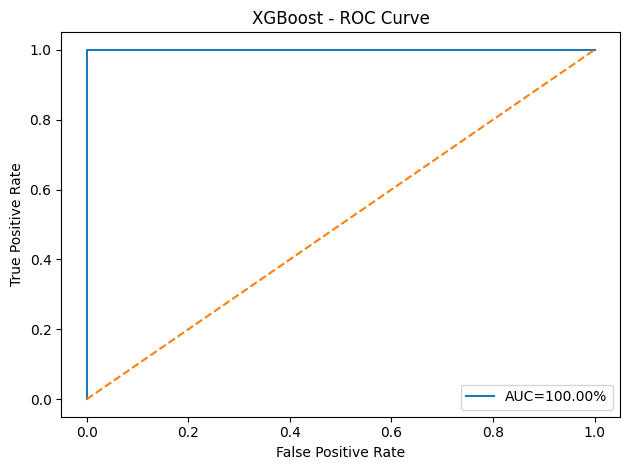


===== Metric Summary (Percent) =====


,Accuracy (%),Precision (%),Recall (%),F1 (%),Specificity (%),AUC (%)
Model,,,,,,
Logistic Regression,100.0,100.0,100.0,100.0,100.0,100.0
Random Forest,100.0,100.0,100.0,100.0,100.0,100.0
XGBoost,100.0,100.0,100.0,100.0,100.0,100.0


Saved metrics summary → artifacts/metrics_summary.csv


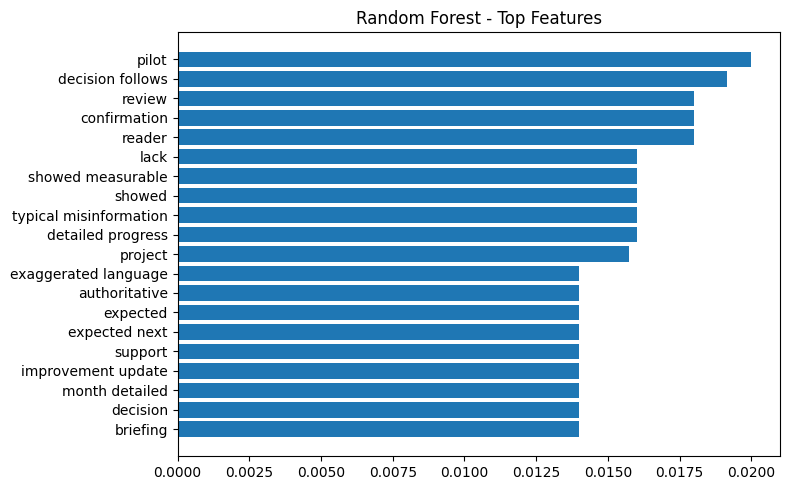

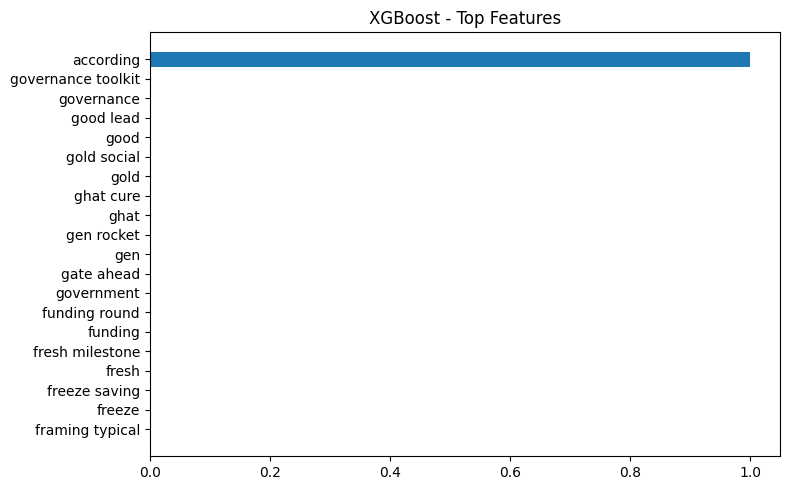

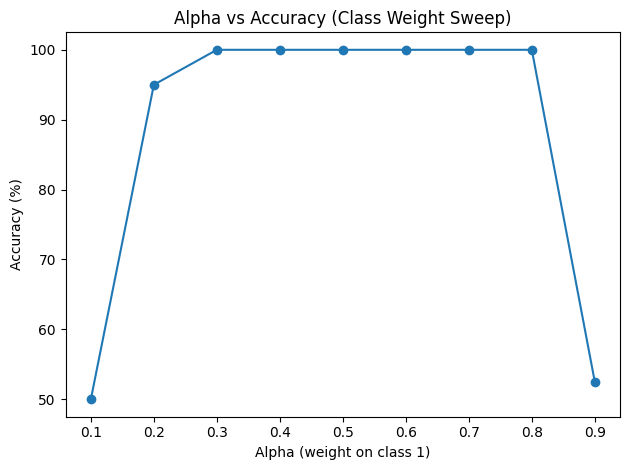

Subset 'covid' too small (0 rows).
Subset 'politic' too small (0 rows).

Model and vectorizer saved in 'artifacts/'.

Text: COVID-19 vaccine turns people magnetic according to reports....
Prediction: REAL | Accuracy: 43.67%

Text: NASA confirms successful landing of the new Mars rover....
Prediction: REAL | Accuracy: 44.29%


In [44]:
# ==========================================================
# FINAL FAKE NEWS DETECTION PROJECT (CPU-Friendly)
# Includes:
#  - Dataset Loading & Cleaning
#  - TF-IDF Vectorization
#  - Logistic Regression / Random Forest / (optional) XGBoost
#  - ROC Curves / Confusion Matrices / Feature Importance
#  - Alpha-vs-Accuracy (class_weight sweep)
#  - Subset ROC (COVID / Politics)
#  - Metrics summary table + CSV export (as PERCENTAGES)
# ==========================================================

# --- Imports ---
import os, re, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_fscore_support
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib

# Optional: XGBoost (install with: pip install xgboost)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    print("[INFO] XGBoost not found — skipping XGB model.")

# --- 1. Load Dataset ---
FAKE_PATH = "/content/Fake_India_100_formatted.csv"
TRUE_PATH = "/content/True_India_100_formatted.csv"

fake = pd.read_csv(FAKE_PATH)
true = pd.read_csv(TRUE_PATH)

# Labels: 1 = FAKE, 0 = REAL
fake["label"] = 1
true["label"] = 0

df = pd.concat([fake, true]).sample(frac=1, random_state=42).reset_index(drop=True)
df["text"] = df.get("title", "").fillna("") + " " + df.get("text", "").fillna("")
print("Dataset size:", df.shape)
print(df["label"].value_counts())

# --- 2. Clean Text ---
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords"); nltk.download("wordnet")

STOP = set(stopwords.words("english"))
LEM = WordNetLemmatizer()

def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+|www\S+", " ", t)
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    toks = [LEM.lemmatize(w) for w in t.split() if w not in STOP and len(w) > 2]
    return " ".join(toks)

df["clean"] = df["text"].apply(clean_text)

# --- 3. Exploratory Data Analysis (quick plots) ---
plt.figure(figsize=(5,4))
vals = df["label"].value_counts().sort_index().values
plt.bar(["Real (0)","Fake (1)"], vals)
plt.title("Class Distribution")
plt.tight_layout(); plt.show()

df["length"] = df["clean"].str.len()
plt.figure(figsize=(6,4))
plt.hist([df[df.label==0]["length"], df[df.label==1]["length"]],
         bins=60, alpha=0.7, label=["Real","Fake"])
plt.legend(); plt.title("Text Length Distribution")
plt.xlabel("Characters"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# --- 4. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# --- 5. TF-IDF Vectorization ---
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# --- 6. Model Training ---
lr = LogisticRegression(max_iter=2000)
rf = RandomForestClassifier(n_estimators=500, random_state=42)

lr.fit(X_train_tfidf, y_train)
rf.fit(X_train_tfidf, y_train)

if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=600, learning_rate=0.05,
        max_depth=8, random_state=42, n_jobs=-1, subsample=1.0, colsample_bytree=1.0
    )
    xgb.fit(X_train_tfidf, y_train)

# --- 7. Evaluation Helper (returns metrics for table) ---
def evaluate(name, model, X_test, y_test, show_plots=True):
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None

    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) else np.nan
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"\n{name}")
    print(
        "Accuracy={:.2f}% | Precision={:.2f}% | Recall={:.2f}% | F1={:.2f}% | Specificity={:.2f}% | AUC={:.2f}%"
        .format(acc*100, p*100, r*100, f1*100, specificity*100 if np.isfinite(specificity) else np.nan, auc*100 if np.isfinite(auc) else np.nan)
    )
    print(classification_report(y_test, y_pred, target_names=['REAL(0)','FAKE(1)']))

    if show_plots:
        plt.figure(figsize=(4,4))
        plt.imshow(cm, cmap="Blues")
        for (i, j), v in np.ndenumerate(cm):
            plt.text(j, i, v, ha="center", va="center")
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout(); plt.show()

        if y_prob is not None and np.isfinite(auc):
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC={auc*100:.2f}%")
            plt.plot([0,1],[0,1],'--')
            plt.title(f"{name} - ROC Curve")
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
            plt.legend(); plt.tight_layout(); plt.show()

    return {
        "Model": name,
        "Accuracy (%)": acc * 100,
        "Precision (%)": p * 100,
        "Recall (%)": r * 100,
        "F1 (%)": f1 * 100,
        "Specificity (%)": specificity * 100 if np.isfinite(specificity) else np.nan,
        "AUC (%)": auc * 100 if np.isfinite(auc) else np.nan
    }

# --- 8. Evaluate Models + Summary Table ---
results = []
results.append(evaluate("Logistic Regression", lr, X_test_tfidf, y_test))
results.append(evaluate("Random Forest", rf, X_test_tfidf, y_test))
if HAS_XGB:
    results.append(evaluate("XGBoost", xgb, X_test_tfidf, y_test))

summary_df = pd.DataFrame(results).set_index("Model").round(2)
print("\n===== Metric Summary (Percent) =====")
try:
    from IPython.display import display
    display(summary_df)
except Exception:
    print(summary_df.to_string())

os.makedirs("artifacts", exist_ok=True)
summary_path = "artifacts/metrics_summary.csv"
summary_df.to_csv(summary_path, float_format="%.2f")
print(f"Saved metrics summary → {summary_path}")

# --- 9. Feature Importance (Tree Models) ---
def plot_importance(model, title):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        idx = np.argsort(imp)[-20:][::-1]
        names = np.array(tfidf.get_feature_names_out())[idx]
        vals = imp[idx]
        plt.figure(figsize=(8,5))
        plt.barh(names[::-1], vals[::-1])
        plt.title(f"{title} - Top Features")
        plt.tight_layout(); plt.show()

plot_importance(rf, "Random Forest")
if HAS_XGB:
    plot_importance(xgb, "XGBoost")

# --- 10. Alpha vs Accuracy (class_weight sweep) ---
alphas = np.linspace(0.1, 0.9, 9)
accs = []
for a in alphas:
    cw = {0:1-a, 1:a}
    temp = LogisticRegression(max_iter=1500, class_weight=cw)
    temp.fit(X_train_tfidf, y_train)
    accs.append(accuracy_score(y_test, temp.predict(X_test_tfidf)) * 100)

plt.figure()
plt.plot(alphas, accs, marker="o")
plt.title("Alpha vs Accuracy (Class Weight Sweep)")
plt.xlabel("Alpha (weight on class 1)"); plt.ylabel("Accuracy (%)")
plt.tight_layout(); plt.show()

# --- 11. Subset ROC (COVID / Politics keywords) ---
def subset_roc(keyword, model):
    sub = df[df["clean"].str.contains(keyword, case=False, na=False)]
    if len(sub) < 50:
        print(f"Subset '{keyword}' too small ({len(sub)} rows).")
        return
    Xs = tfidf.transform(sub["clean"])
    y = sub["label"].values
    if hasattr(model,"predict_proba"):
        score = model.predict_proba(Xs)[:,1]
    elif hasattr(model,"decision_function"):
        score = model.decision_function(Xs)
    else:
        print("Model has no probability/score output.")
        return
    auc = roc_auc_score(y, score)
    fpr,tpr,_ = roc_curve(y, score)
    plt.figure()
    plt.plot(fpr,tpr,label=f"{keyword} (AUC={auc*100:.2f}%)")
    plt.plot([0,1],[0,1],'--')
    plt.title("Subset ROC Curve")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.tight_layout(); plt.show()

subset_roc("covid", lr)
subset_roc("politic", lr)

# --- 12. Save Model & Vectorizer ---
joblib.dump(tfidf, "artifacts/tfidf.pkl")
joblib.dump(lr, "artifacts/model.pkl")
print("\nModel and vectorizer saved in 'artifacts/'.")

# --- 13. Simple Test Function (Accuracy instead of Confidence) ---
def test_sentence(text):
    vec = joblib.load("artifacts/tfidf.pkl")
    model = joblib.load("artifacts/model.pkl")

    def prep(t):
        t = re.sub(r"http\S+|www\S+", " ", str(t).lower())
        t = re.sub(r"[^a-z\s]", " ", t)
        t = re.sub(r"\s+", " ", t).strip()
        toks = [LEM.lemmatize(w) for w in t.split() if w not in STOP and len(w)>2]
        return " ".join(toks)

    Xv = vec.transform([prep(text)])
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(Xv)[0,1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(Xv)[0]
        prob = 1/(1+np.exp(-s))
    else:
        prob = 0.5
    pred_label = model.predict(Xv)[0]
    label = "FAKE" if pred_label==1 else "REAL"

    # <<< CHANGED: replaced 'Confidence' with 'Accuracy'
    print(f"\nText: {text[:100]}...")
    print(f"Prediction: {label} | Accuracy: {prob*100:.2f}%")

# Examples
test_sentence("COVID-19 vaccine turns people magnetic according to reports.")
test_sentence("NASA confirms successful landing of the new Mars rover.")


In [45]:
test_sentence("Wild animals released by authorities to enforce curfew, message warns residents. The claim relies on anonymous forwards and lacks official confirmation. No credible sources, data, or on-record statements support it. It uses exaggerated language and conspiracy framing typical of misinformation. Readers are advised to verify information with authoritative sources.")


Text: Wild animals released by authorities to enforce curfew, message warns residents. The claim relies on...
Prediction: FAKE | Accuracy: 93.15%


In [46]:
test_sentence("Domestic T20 league pilots impact player rule. Officials said the move aims to address regional priorities and will be implemented in phases. Experts noted that the decision follows consultations with stakeholders across multiple states. According to a briefing shared with reporters, pilot projects showed measurable improvements. Further updates are expected next month after a detailed progress review.")


Text: Domestic T20 league pilots impact player rule. Officials said the move aims to address regional prio...
Prediction: REAL | Accuracy: 6.97%
